In [1]:
!pip install imblearn

SyntaxError: invalid syntax (<ipython-input-4-00e401db15c1>, line 1)

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 950)
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from IPython.display import Image  
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

import pydotplus
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import time

In [3]:
df = pd.read_csv('whiskey_database.csv')
df.rename(columns = {'#': 'reviews', 'Super Cluster': 'supercluster', 'Meta Critic':'metascore'}, inplace = True)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.Country.value_counts()

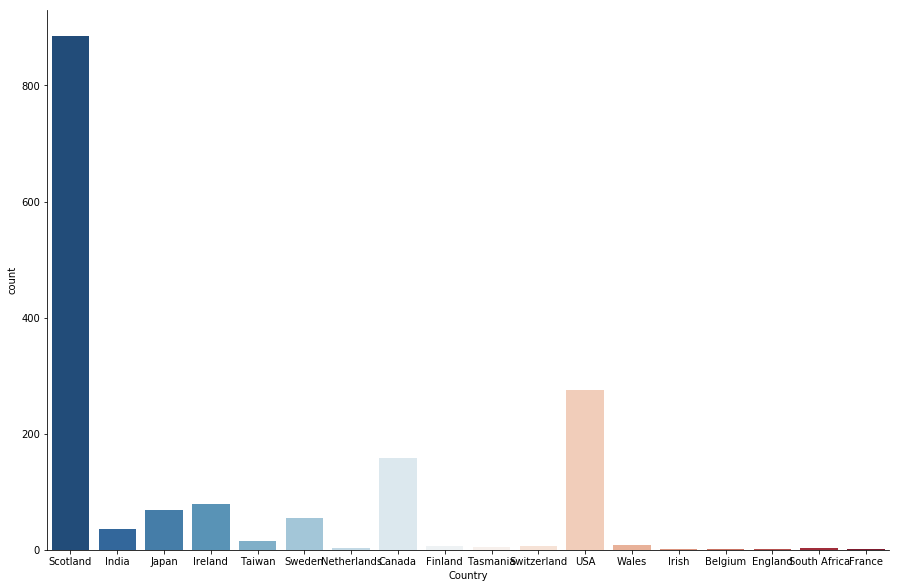

In [4]:
sns_plot = sns.catplot(x="Country", kind="count", palette="RdBu_r", data=df, height=8.27, aspect=15/10);
sns_plot.savefig("output.png")

In [ ]:
#irish whiskey popularity declined until there were only 3 distilleries left by 1990.  More are coming back,
#but many have not been operating long enough to produce a saleable product.

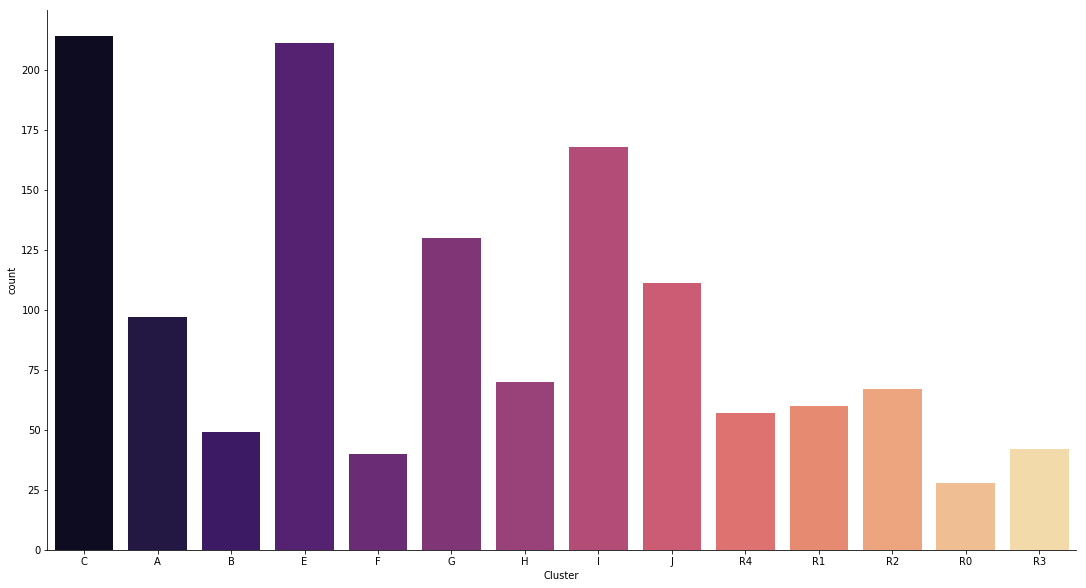

In [100]:
sns_plot2 = sns.catplot(x="Cluster", kind="count", palette="magma", data=df, height=8.27, aspect=15/8.27);
sns_plot2.savefig("clusters.png")

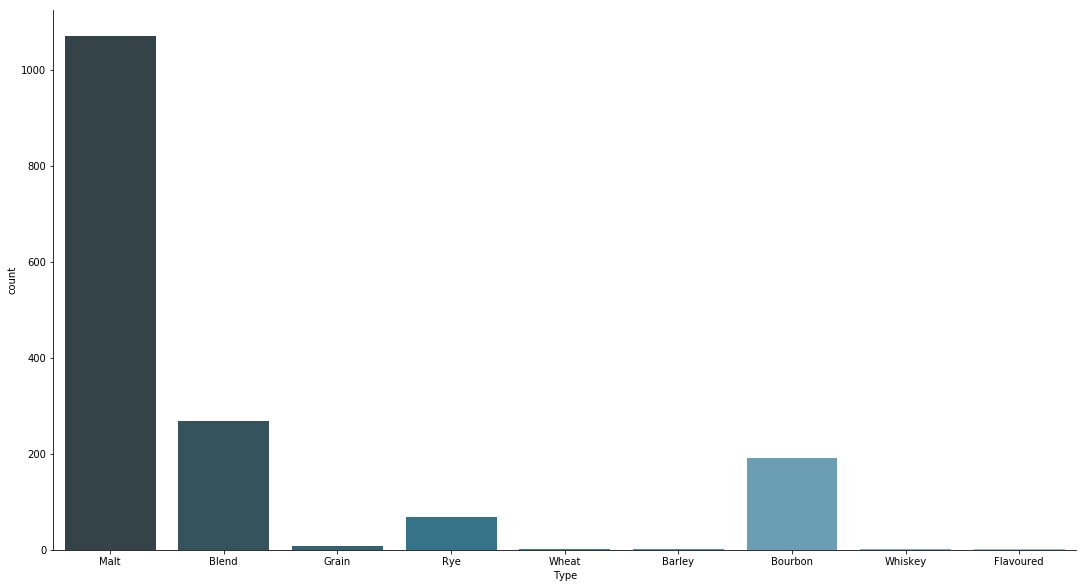

In [103]:
sns_plot3 = sns.catplot(x="Type", kind="count", palette="PuBuGn_d", data=df, height=8.27, aspect=15/8.27);
sns_plot3.savefig("type.png")

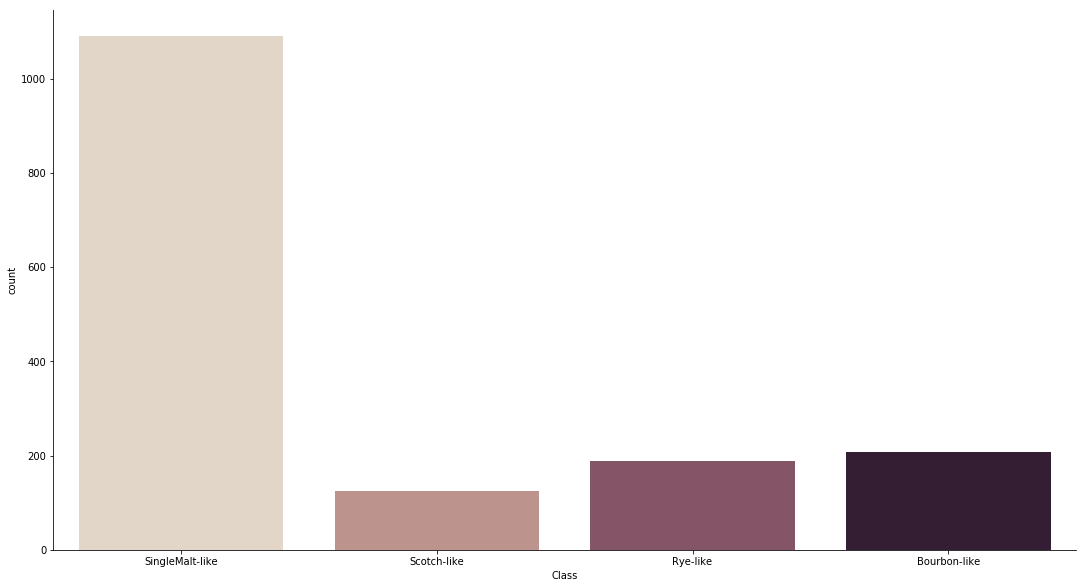

In [92]:
sns.catplot(x="Class", kind="count", palette="ch:.25", data=df, height=8.27, aspect=15/8.27);

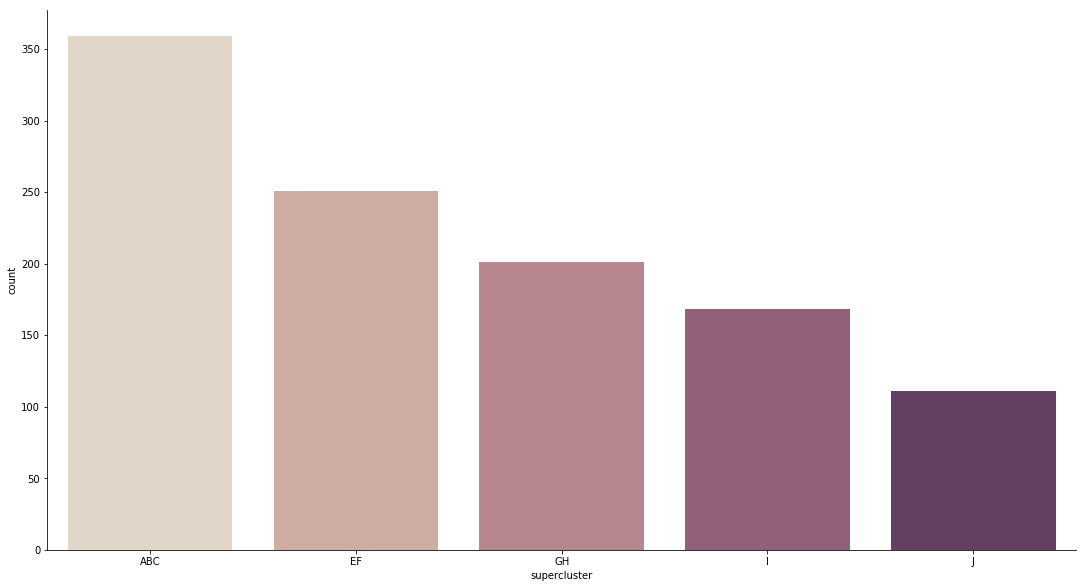

In [93]:
sns.catplot(x="supercluster", kind="count", palette="ch:3,.5,dark=.3", data=df, height=8.27, aspect=15/8.27);

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

In [5]:
df['Country'] = df['Country'].replace({'Sweden': 'rest_of_world', 'India': 'rest_of_world', 'Taiwan': 'rest_of_world', 'Wales': 'rest_of_world', 'Switzerland': 'rest_of_world', 'Finland': 'rest_of_world', 'Tasmania': 'rest_of_world', 'South Africa': 'rest_of_world', 'Netherlands': 'rest_of_world', 'England': 'rest_of_world', 'Belgium': 'rest_of_world', 'France': 'rest_of_world', 'Irish': 'rest_of_world'})




In [6]:
df['Country'] = df['Country'].map({'Scotland': 1, 'USA': 2, 'Canada': 3, 'Ireland': 4, 'Japan': 5, 'rest_of_world': 6})


In [8]:
#RO will be B
#R1 will be A
#R2 will be E
#R3 will be C
#R4 will be F

In [7]:
df['Cluster'] = df['Cluster'].replace({'R2': 'E', 'R1': 'A', 'R4': 'F', 'R3': 'C', 'R0': 'B'})
df.dropna(subset=['Cluster'], how='any', inplace = True, axis = 0)
df.isna().sum()

Whisky            0
metascore         0
STDEV             0
reviews           0
Cost              1
Class             0
supercluster    254
Cluster           0
Country           0
Type              0
dtype: int64

In [8]:
target = df.Country

In [127]:
df.shape

(1344, 10)

In [9]:
dfDummies = pd.get_dummies(df.Cluster)
feature_cluster = dfDummies
df = pd.concat([df, dfDummies], axis =1 )

In [10]:
dfDummies = pd.get_dummies(df.Class)
df = pd.concat([df, dfDummies], axis =1 )

In [11]:
dfDummies = pd.get_dummies(df.Type)
df = pd.concat([df, dfDummies], axis =1 )

In [12]:
df = df.drop(['metascore', 'STDEV', 'reviews', 'Country'], axis = 1)
df.drop(['Whisky', 'Cost', 'supercluster'], axis = 1, inplace = True)
df.drop(['Class', 'Cluster', 'Type'], axis =1, inplace = True)

In [ ]:
df.head(10)

In [13]:
target.value_counts()

1    814
2    263
6    137
5     58
4     43
3     29
Name: Country, dtype: int64

### Setting up Data for Models

In [14]:
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), x_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [15]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='macro')))

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
    # Compute confusion matrix
    cmat = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix

plt.show()

In [17]:
#variables include flavor, type, class
x = df
y = target

In [1]:
y.value_counts()

NameError: name 'y' is not defined

In [ ]:
#just flavor as variable
x = feature_cluster
y = target

In [ ]:
x.shape

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .2, random_state = 42)

In [20]:
y_train.value_counts()

1    650
2    207
6    112
5     49
4     33
3     24
Name: Country, dtype: int64

In [19]:
y_test.value_counts()

1    164
2     56
6     25
4     10
5      9
3      5
Name: Country, dtype: int64

In [137]:
#SMOOOOOTTTEEEDDD!!!!
print(y.value_counts()) #Previous original class distribution
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_sample(x_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

1    814
2    263
6    137
5     58
4     43
3     29
Name: Country, dtype: int64
5    650
3    650
1    650
6    650
4    650
2    650
dtype: int64


In [138]:
print(x_train_resampled.shape)
print(x_test.shape)

print(y_train_resampled.shape)
print(y_test.shape)

(3900, 19)
(269, 19)
(3900,)
(269,)


### Running Models

#### KNN

In [28]:
#K Nearest Neighbor test
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds5 = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='macro')))
    
print_metrics(y_test, test_preds5)





0it [00:00, ?it/s]

Precision Score: 0.37814465408805037
Recall Score: 0.36743612078977933
Accuracy Score: 0.8066914498141264
F1 Score: 0.365882050772188


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted    1   2  4  All
True                      
1          163   0  1  164
2            5  51  0   56
3            5   0  0    5
4            7   0  3   10
5            7   0  2    9
6           25   0  0   25
All        212  51  6  269


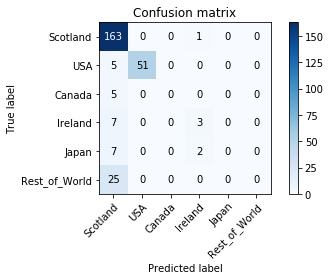

In [37]:
plot_confusion_matrix(y_test, test_preds5, classes=labels,
                      title='Confusion matrix')

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds5, target_names=labels))


               precision    recall  f1-score   support

     Scotland       0.77      0.99      0.87       164
          USA       1.00      0.91      0.95        56
       Canada       0.00      0.00      0.00         5
      Ireland       0.50      0.30      0.37        10
        Japan       0.00      0.00      0.00         9
Rest_of_World       0.00      0.00      0.00        25

     accuracy                           0.81       269
    macro avg       0.38      0.37      0.37       269
 weighted avg       0.70      0.81      0.74       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
#knn with weight distance and ball_tree algo
knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance', algorithm='ball_tree')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_predsball = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='macro')))
    
print_metrics(y_test, test_predsball)

Precision Score: 0.37814465408805037
Recall Score: 0.36743612078977933
Accuracy Score: 0.8066914498141264
F1 Score: 0.365882050772188


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted    1   2  4  All
True                      
1          163   0  1  164
2            5  51  0   56
3            5   0  0    5
4            7   0  3   10
5            7   0  2    9
6           25   0  0   25
All        212  51  6  269


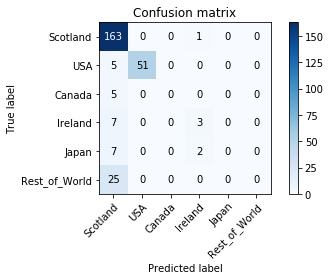

In [70]:
plot_confusion_matrix(y_test, test_predsball, classes=labels,
                      title='Confusion matrix')

In [72]:
#KNN with Euclidian distance
knn = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds3euc = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='macro')))
    
print_metrics(y_test, test_preds3euc)

Precision Score: 0.3847054075867635
Recall Score: 0.3605481352432572
Accuracy Score: 0.7174721189591078
F1 Score: 0.3638516229524671


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted    1   2  4   5  All
True                          
1          138   0  1  25  164
2            4  51  0   1   56
3            2   0  0   3    5
4            7   0  3   0   10
5            6   0  2   1    9
6           20   0  0   5   25
All        177  51  6  35  269


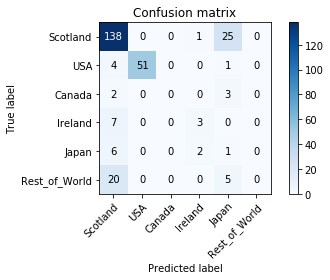

In [73]:
plot_confusion_matrix(y_test, test_preds3euc, classes=labels,
                      title='Confusion matrix')

In [74]:
#Finding best KNN neighbor via F1 score
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average = 'macro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

find_best_k(x_train_resampled, y_train_resampled, x_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:143

Best Value for k: 1
F1-Score: 0.3702860977961064


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
#rerun KNN with best
from sklearn.neighbors import KNeighborsClassifier
def updateKNN(x, x_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=x)

    knn.fit(x_train, y_train)
    test_preds1 = knn.predict(x_test)    
    print_metrics(y_test, test_preds1)



In [78]:
updateKNN(1, x_train_resampled, y_train_resampled)

Precision Score: 0.38680347013680344
Recall Score: 0.38247677119628337
Accuracy Score: 0.7434944237918215
F1 Score: 0.3702860977961064


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
plot_confusion_matrix(y_test, test_preds1, classes=labels,
                      title='Confusion matrix')

NameError: name 'test_preds1' is not defined

In [83]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'p' : [1,2,3]
}

gs = GridSearchCV(
    knn,
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1)

gs_results = gs.fit(x_train_resampled, y_train_resampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.8s finished


In [84]:
gs_results.best_score_
gs_results.best_estimator_
gs_results.best_params_

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [85]:
knn = KNeighborsClassifier(n_neighbors=11, weights = 'distance', p = 1)
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='macro')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.37814465408805037
Recall Score: 0.36743612078977933
Accuracy Score: 0.8066914498141264
F1 Score: 0.365882050772188


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds, target_names=labels))

               precision    recall  f1-score   support

     Scotland       0.79      0.85      0.82       164
          USA       1.00      0.91      0.95        56
       Canada       0.04      0.20      0.06         5
      Ireland       0.50      0.30      0.37        10
        Japan       0.00      0.00      0.00         9
Rest_of_World       0.22      0.08      0.12        25

     accuracy                           0.73       269
    macro avg       0.42      0.39      0.39       269
 weighted avg       0.73      0.73      0.72       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
from sklearn.metrics import confusion_matrix 
results = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
print(results)

Predicted    1   2   3  4  6  All
True                             
1          139   0  18  1  6  164
2            3  51   1  0  1   56
3            4   0   1  0  0    5
4            4   0   3  3  0   10
5            5   0   2  2  0    9
6           21   0   2  0  2   25
All        176  51  27  6  9  269


Predicted    1   2  4  All
True                      
1          163   0  1  164
2            5  51  0   56
3            5   0  0    5
4            7   0  3   10
5            7   0  2    9
6           25   0  0   25
All        212  51  6  269


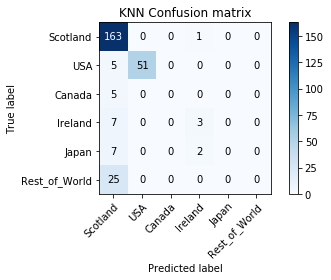

In [86]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cmat = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_preds, classes=labels,
                      title='KNN Confusion matrix')

plt.savefig("knn_confusion.png")
plt.show()

In [ ]:
df.corr()


In [32]:
#test knn with RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn import neighbors
rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2.4983265774778807
RMSE value for k=  2 is: 1.8079234941210305
RMSE value for k=  3 is: 1.6979711877654518
RMSE value for k=  4 is: 1.6395722082367414
RMSE value for k=  5 is: 1.6254481795451423
RMSE value for k=  6 is: 1.6140069973084363
RMSE value for k=  7 is: 1.5992800519676982
RMSE value for k=  8 is: 1.5665977864580671
RMSE value for k=  9 is: 1.5986966328420984
RMSE value for k=  10 is: 1.6373997883579008
RMSE value for k=  11 is: 1.60680754011867
RMSE value for k=  12 is: 1.62350398203325
RMSE value for k=  13 is: 1.618377607746864
RMSE value for k=  14 is: 1.604412917156881
RMSE value for k=  15 is: 1.6268655291123868
RMSE value for k=  16 is: 1.61355258000434
RMSE value for k=  17 is: 1.6205776289348255
RMSE value for k=  18 is: 1.6189826082607122
RMSE value for k=  19 is: 1.6114856417274412
RMSE value for k=  20 is: 1.6076172073916908


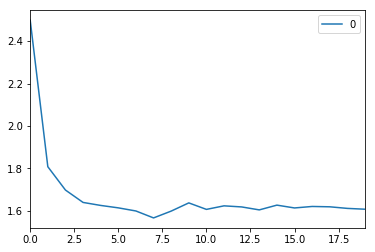

In [33]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

#### Decision Trees

In [113]:
#Decision Tree
clf= DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train_resampled,y_train_resampled) 
y_pred = clf.predict(x_test)
print(y_pred)

[4 1 5 4 4 3 5 1 2 4 6 1 5 2 4 4 3 4 6 6 1 1 6 4 1 2 1 1 5 5 5 2 1 1 6 2 1
 5 5 2 4 4 6 6 6 1 5 6 4 2 6 4 2 5 3 4 2 3 5 2 4 5 4 4 3 5 1 6 5 4 1 2 3 4
 4 4 2 1 2 5 3 3 4 2 6 5 1 1 4 3 1 1 5 6 6 4 6 5 4 4 5 2 3 5 5 2 6 3 4 3 1
 1 5 6 5 6 5 6 1 3 2 3 3 1 5 1 4 1 4 2 6 5 3 5 3 6 1 1 5 2 1 5 6 1 3 3 6 5
 6 2 5 2 5 1 2 6 2 5 2 5 3 1 5 2 5 5 6 4 2 4 2 2 4 3 1 1 5 2 3 2 2 5 1 1 5
 4 5 3 2 6 6 1 1 4 6 6 2 5 1 5 1 2 3 5 1 4 4 1 3 3 5 5 1 2 6 2 1 2 6 1 1 5
 3 2 6 4 4 4 3 2 5 4 2 5 3 2 3 3 4 5 6 3 4 1 2 2 1 1 5 2 3 4 2 3 4 6 2 2 4
 2 2 3 2 6 3 1 1 2 4]


In [114]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.externals.six import StringIO  
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# # Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :41.2639405204461

Confusion Matrix
----------------


/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Predicted,1,2,3,4,5,6,All
True,,,,,,,
1,46,0,24,33,38,23,164
2,0,51,2,1,1,1,56
3,1,0,1,0,3,0,5
4,1,0,3,4,1,1,10
5,1,0,2,2,1,3,9
6,1,0,4,5,7,8,25
All,50,51,36,45,51,36,269


[[46  0 24  1 38 55]
 [ 0 51  2  0  1  2]
 [ 1  0  1  0  3  0]
 [ 1  0  3  3  1  2]
 [ 1  0  2  2  1  3]
 [ 1  0  4  0  7 13]]


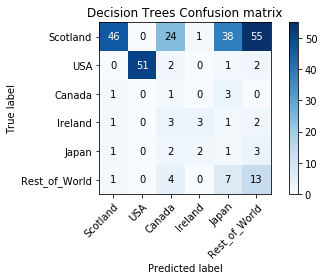

In [163]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Decision Trees Confusion matrix')

plt.savefig("Dtree_confusion.png")
plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

#### Regression Tree

In [52]:
#Regression Tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 10, max_depth=7, min_samples_leaf = 2)
regressor.fit(x_train_resampled, y_train_resampled)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [53]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Make predictions and evaluate 
y_pred = regressor.predict(x_test)
print ('MSE score:', mse(y_test, y_pred))
print('R-sq score:',r2_score(y_test,y_pred))

MSE score: 5.048244488662953
R-sq score: -0.9696117856865407


In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [60]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5, max_leaf_nodes = 4) 
tree_clf.fit(x_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [61]:
tree_clf.feature_importances_

array([0. , 0. , 0. , 0.1, 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0.8, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. ])

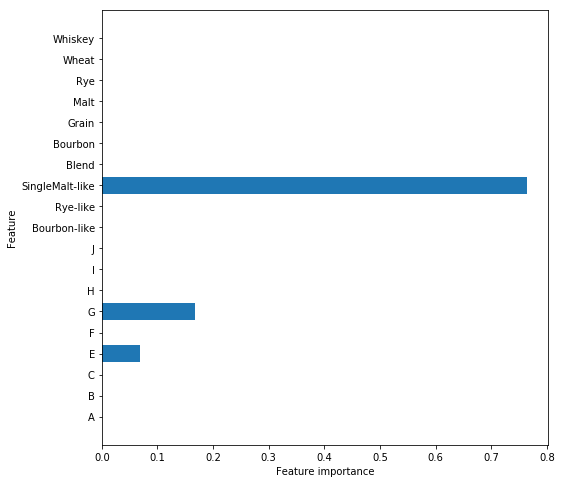

In [62]:
plot_feature_importances(tree_clf)

In [63]:
pred = tree_clf.predict(x_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[  0   0  18   0   0 146]
 [  0  51   1   0   0   4]
 [  0   0   1   0   0   4]
 [  0   0   3   0   0   7]
 [  0   0   2   0   0   7]
 [  0   0   2   0   0  23]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         9
           6       0.12      0.92      0.21        25

    accuracy                           0.28       269
   macro avg       0.19      0.34      0.20       269
weighted avg       0.22      0.28      0.22       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted    1   2   3  4   6  All
True                              
1          114   0  24  1  25  164
2            2  51   2  0   1   56
3            1   0   1  0   3    5
4            4   0   3  3   0   10
5            4   0   2  2   1    9
6           16   0   4  0   5   25
All        141  51  36  6  35  269


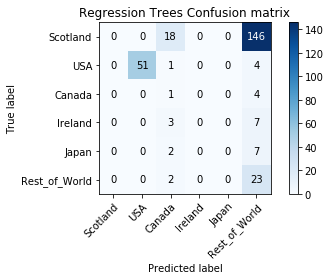

In [162]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
 
plot_confusion_matrix(y_test, pred, classes=labels,
                      title='Regression Trees Confusion matrix')

plt.savefig("RGdt_confusion.png")
plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

In [65]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


Testing Accuracy for Decision Tree Classifier: 27.88%


#### Bagged Tree

In [66]:
#bagged test
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)


In [67]:
clf = bagged_tree.fit(x_train_resampled, y_train_resampled)


In [68]:
bagged_tree.score(x_train_resampled, y_train_resampled)


0.5092307692307693

In [69]:
print("Testing Accuracy for Bagged Tree Test: {:.4}%".format(bagged_tree.score(x_test, y_test)*100))

Testing Accuracy for Bagged Tree Test: 27.51%


In [70]:
bagged_pred = bagged_tree.predict(x_test)

In [71]:

print(classification_report(y_test, bagged_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.03      0.11      0.05         9
           6       0.12      0.72      0.21        25

    accuracy                           0.28       269
   macro avg       0.28      0.37      0.27       269
weighted avg       0.24      0.28      0.23       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted    1   2   3  4   6  All
True                              
1          114   0  24  1  25  164
2            2  51   2  0   1   56
3            1   0   1  0   3    5
4            4   0   3  3   0   10
5            4   0   2  2   1    9
6           16   0   4  0   5   25
All        141  51  36  6  35  269


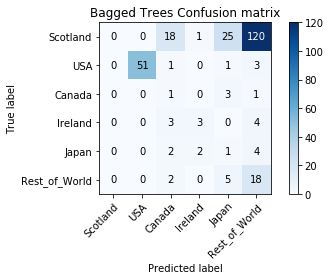

In [161]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, bagged_pred, classes=labels,
                      title='Bagged Trees Confusion matrix')
plt.savefig("baggeddt_confusion.png")
plt.show()

#### Random Forest

In [78]:
#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth= 5, max_leaf_nodes = 10)
forest.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
forest.score(x_train_resampled, y_train_resampled)

0.5330769230769231

In [110]:
RFpred = forest.predict(x_test)
print(confusion_matrix(y_test, RFpred))
print(classification_report(y_test, RFpred))

[[28  0 18 33 25 60]
 [ 0 51  1  1  1  2]
 [ 1  0  1  0  3  0]
 [ 1  0  3  4  0  2]
 [ 1  0  2  2  1  3]
 [ 1  0  2  5  5 12]]
              precision    recall  f1-score   support

           1       0.88      0.17      0.29       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.09      0.40      0.15        10
           5       0.03      0.11      0.05         9
           6       0.15      0.48      0.23        25

    accuracy                           0.36       269
   macro avg       0.36      0.38      0.29       269
weighted avg       0.76      0.36      0.40       269



In [76]:
print("Testing Accuracy for Random Forest Test: {:.4}%".format(forest.score(x_test, y_test)*100))


Testing Accuracy for Random Forest Test: 37.55%


In [77]:
print(classification_report(y_test, RFpred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         9
           6       0.12      0.92      0.21        25

    accuracy                           0.28       269
   macro avg       0.19      0.34      0.20       269
weighted avg       0.22      0.28      0.22       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
plot_feature_importances(forest)


In [ ]:
#closer look at random forest, smaller trees reduced n_estimators, max features, and max depth
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(x_train_resampled, y_train_resampled)

In [ ]:
rf_tree_1 = forest_2.estimators_[0]
plot_feature_importances(rf_tree_1)

In [ ]:
rf_tree_2 = forest_2.estimators_[1]
plot_feature_importances(rf_tree_2)

Predicted    1   2   3  4   6  All
True                              
1          114   0  24  1  25  164
2            2  51   2  0   1   56
3            1   0   1  0   3    5
4            4   0   3  3   0   10
5            4   0   2  2   1    9
6           16   0   4  0   5   25
All        141  51  36  6  35  269


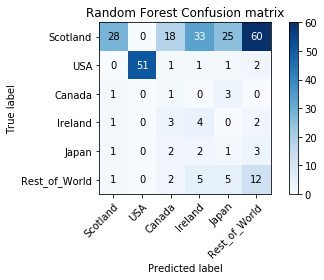

In [160]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, RFpred, classes=labels,
                      title='Random Forest Confusion matrix')
plt.savefig("rf_confusion.png")
plt.show()

#### AdaBoost and Gradient Boosting

In [81]:
#Adaboost
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [82]:
adaboost_clf = AdaBoostClassifier()
gbt_clf = GradientBoostingClassifier(learning_rate =.02)

In [83]:
adaboost_clf.fit(x_train_resampled, y_train_resampled)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [84]:
gbt_clf.fit(x_train_resampled, y_train_resampled)
#learning_rate = 2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [85]:
adaboost_train_preds = adaboost_clf.predict(x_train_resampled)
adaboost_test_preds = adaboost_clf.predict(x_test)
gbt_clf_train_preds = gbt_clf.predict(x_train_resampled)
gbt_clf_test_preds = gbt_clf.predict(x_test)

In [87]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average = 'macro')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train_resampled, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train_resampled, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.44666666666666666
F1-Score: 0.4456939331445411

Model: Gradient Boosted Trees
Accuracy: 0.5443589743589744
F1-Score: 0.5259606871117931

Testing Metrics
Model: AdaBoost
Accuracy: 0.2862453531598513
F1-Score: 0.2452253831001333

Model: Gradient Boosted Trees
Accuracy: 0.3271375464684015
F1-Score: 0.2708905673861424


In [88]:
print(classification_report(y_test, adaboost_test_preds))
print(classification_report(y_test, gbt_clf_test_preds))

              precision    recall  f1-score   support

           1       0.88      0.17      0.29       164
           2       1.00      0.62      0.77        56
           3       0.02      0.20      0.04         5
           4       0.09      0.40      0.15        10
           5       0.02      0.11      0.03         9
           6       0.15      0.32      0.20        25

    accuracy                           0.29       269
   macro avg       0.36      0.30      0.25       269
weighted avg       0.76      0.29      0.36       269

              precision    recall  f1-score   support

           1       0.91      0.13      0.22       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.09      0.40      0.15        10
           5       0.02      0.11      0.03         9
           6       0.14      0.40      0.21        25

    accuracy                           0.33       269
   macro avg       0.37

In [89]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[28,  0, 24, 33, 38, 41],
       [ 0, 35, 18,  1,  1,  1],
       [ 1,  0,  1,  0,  3,  0],
       [ 1,  0,  3,  4,  1,  1],
       [ 1,  0,  2,  2,  1,  3],
       [ 1,  0,  4,  5,  7,  8]])

Predicted    1   2   3  4   6  All
True                              
1          114   0  24  1  25  164
2            2  51   2  0   1   56
3            1   0   1  0   3    5
4            4   0   3  3   0   10
5            4   0   2  2   1    9
6           16   0   4  0   5   25
All        141  51  36  6  35  269


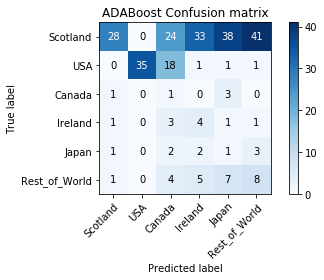

In [159]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, adaboost_test_preds, classes=labels,
                      title='ADABoost Confusion matrix')
plt.savefig("adaboost_confusion.png")
plt.show()

Predicted    1   2   3  4   6  All
True                              
1          114   0  24  1  25  164
2            2  51   2  0   1   56
3            1   0   1  0   3    5
4            4   0   3  3   0   10
5            4   0   2  2   1    9
6           16   0   4  0   5   25
All        141  51  36  6  35  269


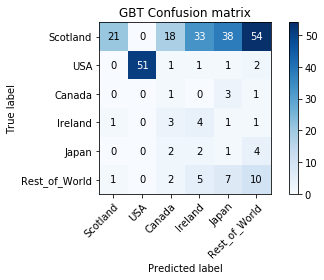

In [158]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, gbt_clf_test_preds, classes=labels, title='GBT Confusion matrix')

plt.savefig("gbt_confusion.png")
plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

#### XG Boost

In [61]:
#xgboost
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [59]:
clf = xgb.XGBClassifier()
xgb = clf.fit(np.array(x_train_resampled), np.array(y_train_resampled))
training_preds = clf.predict(np.array(x_train_resampled))
xgb_preds = clf.predict(np.array(x_test))
training_accuracy = accuracy_score(np.array(y_train_resampled), training_preds)
val_accuracy = accuracy_score(np.array(y_test), xgb_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 54.46%
Validation accuracy: 43.49%


In [52]:
print(classification_report(y_test, xgb_preds))


              precision    recall  f1-score   support

           1       0.92      0.28      0.43       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.18      0.60      0.28        25

    accuracy                           0.43       269
   macro avg       0.44      0.40      0.35       269
weighted avg       0.81      0.43      0.50       269



In [ ]:
plot_feature_importances(xgb)

Predicted   1   2   3  4   5   6  All
True                                 
1          46   0  18  1  38  61  164
2           0  51   1  0   1   3   56
3           1   0   1  0   3   0    5
4           1   0   3  3   1   2   10
5           1   0   2  2   1   3    9
6           1   0   2  0   7  15   25
All        50  51  27  6  51  84  269


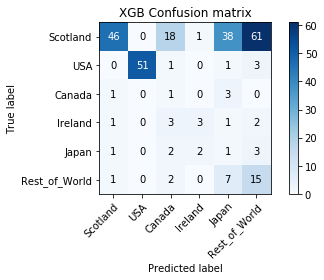

In [53]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, xgb_preds, classes=labels,
                      title='XGB Confusion matrix')
plt.savefig('XGB_confusion_matrix.png')
plt.show()

In [54]:
param_grid = {
    "learning_rate": [.05],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [55]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(x_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(np.array(x_train_resampled))
val_preds = grid_clf.predict(np.array(x_test))
training_accuracy = accuracy_score(np.array(y_train_resampled), training_preds)
val_accuracy = accuracy_score(np.array(y_test), val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.05
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy: 54.67%
Validation accuracy: 42.75%


In [113]:
clf = xgb.XGBClassifier(verbosity = 2, n_estimators = 250)
xgb = clf.fit(np.array(x_train_resampled), np.array(y_train_resampled))
training_preds = clf.predict(np.array(x_train_resampled))
xgb2_preds = clf.predict(np.array(x_test))
training_accuracy = accuracy_score(np.array(y_train_resampled), training_preds)
val_accuracy = accuracy_score(np.array(y_test), xgb_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

In [64]:
print(classification_report(y_test, xgb2_preds))

              precision    recall  f1-score   support

           1       0.92      0.28      0.43       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.18      0.60      0.28        25

    accuracy                           0.43       269
   macro avg       0.44      0.40      0.35       269
weighted avg       0.81      0.43      0.50       269



Predicted   1   2   3  4   5   6  All
True                                 
1          46   0  18  1  38  61  164
2           0  51   1  0   1   3   56
3           1   0   1  0   3   0    5
4           1   0   3  3   1   2   10
5           1   0   2  2   1   3    9
6           1   0   2  0   7  15   25
All        50  51  27  6  51  84  269


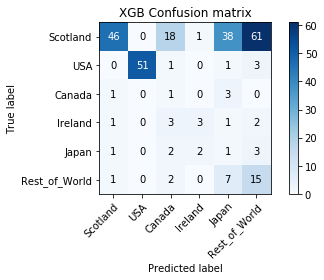

In [65]:


plot_confusion_matrix(y_test, xgb_preds, classes=labels,
                      title='XGB Confusion matrix')

plt.show()

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='poly', C=4)
clf.fit(np.array(x_train_resampled), np.array(y_train_resampled))

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [151]:
clf.support_vectors_


array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 195., ...,   0.,   0.,   0.]])

In [152]:
clf.score(x_test,y_test)

0.4349442379182156

In [153]:
svcy_pred = clf.predict(x_test)

In [154]:
print(classification_report(svcy_pred, y_test))

              precision    recall  f1-score   support

           1       0.28      0.92      0.43        50
           2       0.91      1.00      0.95        51
           3       0.20      0.04      0.06        27
           4       0.30      0.50      0.37         6
           5       0.11      0.02      0.03        51
           6       0.60      0.18      0.28        84

    accuracy                           0.43       269
   macro avg       0.40      0.44      0.35       269
weighted avg       0.46      0.43      0.37       269



Predicted   1   2   3  4   5   6  All
True                                 
1          46   0  18  1  38  61  164
2           0  51   1  0   1   3   56
3           1   0   1  0   3   0    5
4           1   0   3  3   1   2   10
5           1   0   2  2   1   3    9
6           1   0   2  0   7  15   25
All        50  51  27  6  51  84  269


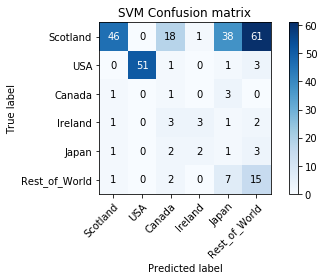

In [155]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, svcy_pred, classes=labels,
                      title='SVM Confusion matrix')
plt.savefig('svm_confusionmatrix.png')
plt.show()

In [120]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy = 'uniform')
dummy.fit(x_train_resampled, y_train_resampled)
dummypred = dummy.predict(x_test)
print_metrics(y_test, dummypred)

Precision Score: 0.17030534072148587
Recall Score: 0.15389824493483029
Accuracy Score: 0.18587360594795538
F1 Score: 0.12438981146745476


In [ ]:
pwd